# Import

In [1]:
import csv
import os
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.mixture import BayesianGaussianMixture
from tqdm import tqdm

## Add configuration file

In [2]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")

In [3]:
from ALL import config 
from util import *

## Set condition

In [4]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [5]:
data_type="AgNewsTitle"
vectorize_type = "sentenceBERT"

# Read data

In [6]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [7]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [8]:
max_vector_model_num = config["vectorize"][vectorize_type]["max_model_num"]
# vector_dims = config["vectorize"][vectorize_type]["dims"]
vector_dims = [20]
normalization = config["vectorize"][vectorize_type]["normalization"]
# model_nums = config["clustering"]["gmm"]["max_model_num"]
model_nums = 1
# covariance_types = config["clustering"]["gmm"]["covariance_types"]
covariance_types = ["full"]
weight_concentration_priors = [1000000, 10000, 100, 10, 1, 10e-2, 10e-10, 10e-20, 10e-40, 10e-80, 10e-100]

In [9]:
n_components = config["data"][data_type]["class_num"]

# Clustering

In [10]:
def getGMM(
    vectors, n_components, covariance_type, weight_concentration_prior, seed, path
):
    gmm = BayesianGaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=seed,
        max_iter=1000,
        init_params="k-means++",
        weight_concentration_prior_type="dirichlet_process",
        n_init=1,
        weight_concentration_prior=weight_concentration_prior,
    )
    gmm.fit(vectors)
    # save model
    os.makedirs(os.path.dirname(path), exist_ok=True)
    pickle.dump(gmm, open(path, "wb"))
    pred = gmm.predict(vectors)
    return pred

In [11]:
vectors_path = f"../data/{data_type}/{vectorize_type}/vector"
models_path = f"../data/{data_type}/{vectorize_type}/BayesianGMM/model"
pred_path = f"../data/{data_type}/{vectorize_type}/BayesianGMM/pred"

In [12]:
preds = {}
for vector_model_num in range(max_vector_model_num):
    for vector_dim in vector_dims:
        for model_num in range(model_nums):
            for covariance_type in covariance_types:
                for weight_concentration_prior in tqdm(weight_concentration_priors):
                    vectors = np.load(
                        f"{vectors_path}/{vector_dim}/{normalization}/{vector_model_num}.npy"
                    )
#                     vectors = vectors[2000:3000]
                    pred = getGMM(
                        vectors,
                        seed=model_num,
                        n_components=100,
                        covariance_type=covariance_type,
                        weight_concentration_prior=weight_concentration_prior,
                        path=f"{models_path}/{vector_dim}/{normalization}/{covariance_type}/{model_num}.sav",
                    )
                    preds[weight_concentration_prior] = pred
                    # save prediction
                    np.save(
                        make_filepath(
                            f"{pred_path}/{vector_dim}/{normalization}/{covariance_type}/{model_num}.npy"
                        ),
                        pred,
                    )

100%|██████████| 11/11 [3:01:27<00:00, 989.73s/it]  


In [13]:
send_line_notify(f"Bayesian {data_type} {vectorize_type}")

In [14]:
import matplotlib.pyplot as plt

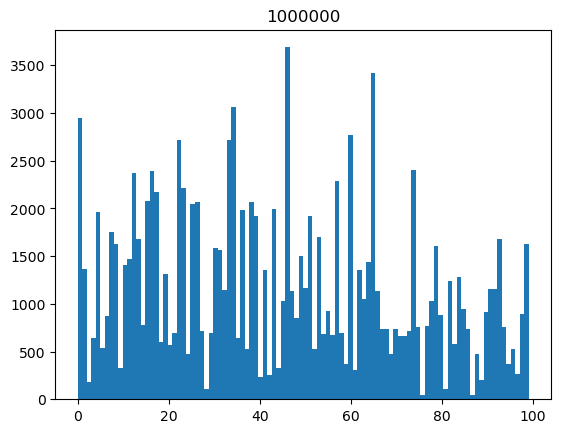

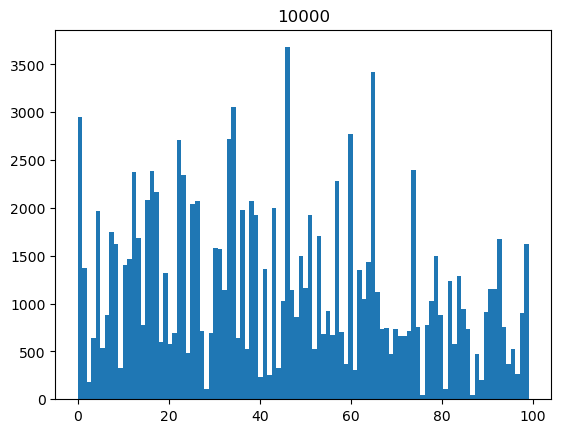

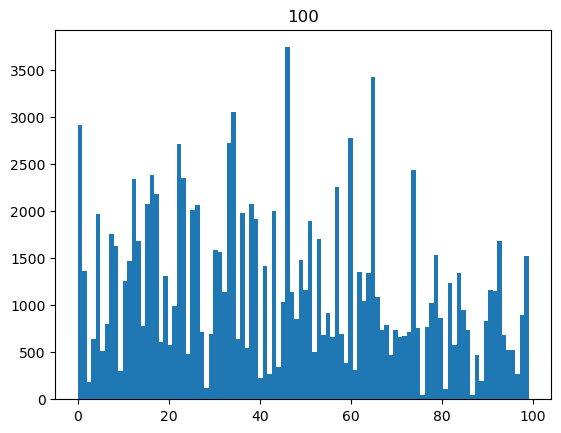

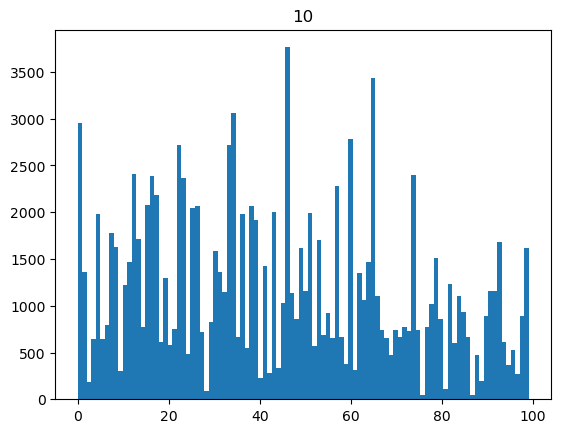

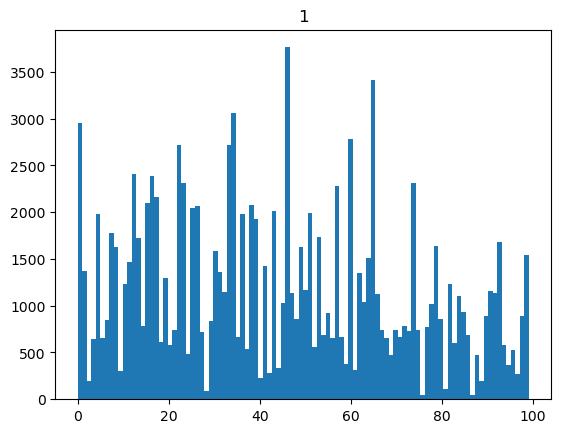

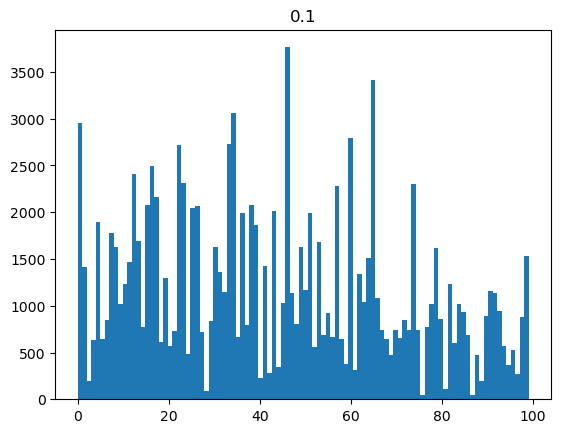

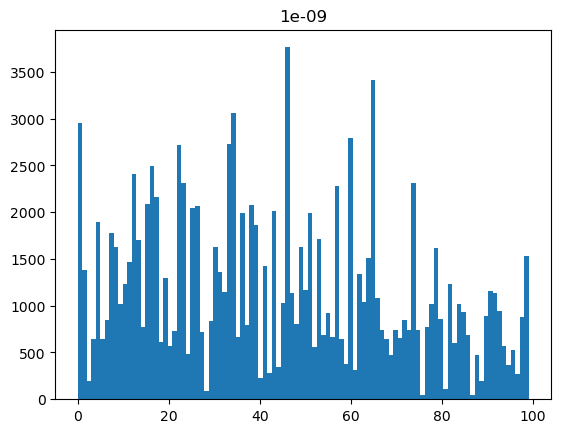

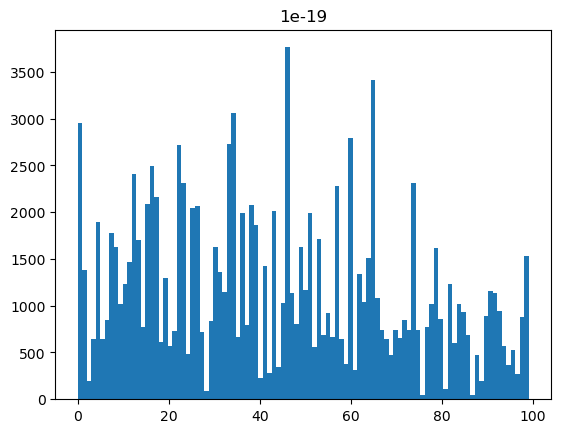

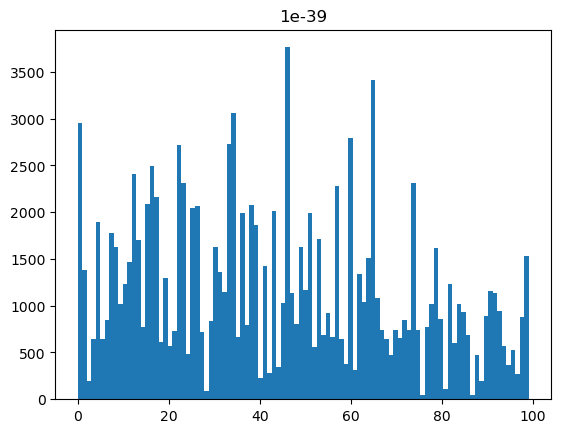

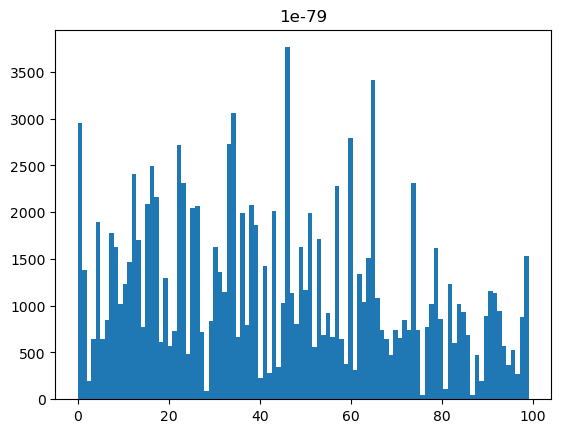

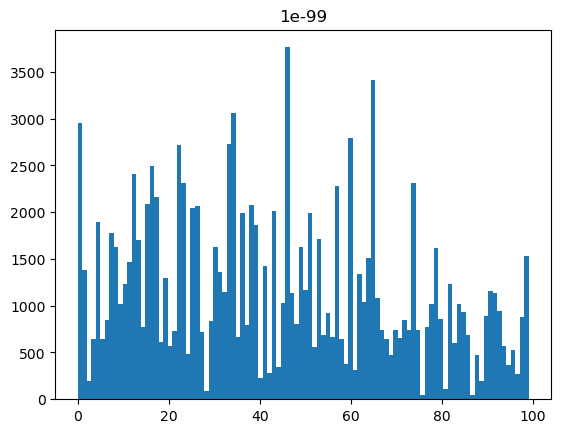

In [15]:
for prior, pred in preds.items():
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(pred, bins= len(set(pred)))
    ax.set_title(prior)

In [17]:
for prior, pred in preds.items():
    print(prior, len(set(pred)))

1000000 100
10000 100
100 100
10 100
1 100
0.1 100
1e-09 100
1e-19 100
1e-39 100
1e-79 100
1e-99 100


In [16]:
aic = {}
for prior, pred in preds.items():
    aic[prior] = adjusted_mutual_info_score(pred, df["class"].to_numpy())

In [18]:
aic

{1000000: 0.2941679802289008,
 10000: 0.29418058631112975,
 100: 0.2939191930453982,
 10: 0.29434540410665533,
 1: 0.294308162281419,
 0.1: 0.29397316538773505,
 1e-09: 0.2939620897328269,
 1e-19: 0.2939620897328269,
 1e-39: 0.2939620897328269,
 1e-79: 0.2939620897328269,
 1e-99: 0.2939620897328269}

In [17]:
for prior, pred in preds.items():
    print(prior, len(set(pred)))

1000000 20
10000 19
100 17
10 17
1 17
0.1 17
1e-09 17
1e-19 17
1e-39 17
1e-79 17
1e-99 17


In [20]:
aic

{1000000: 0.2779991029824499,
 10000: 0.27858880488965226,
 100: 0.2846808982145474,
 10: 0.2846766499247059,
 1: 0.2846766499247059,
 0.1: 0.2846766499247059,
 1e-09: 0.2846766499247059,
 1e-19: 0.2846766499247059,
 1e-39: 0.2846766499247059,
 1e-79: 0.2846766499247059,
 1e-99: 0.2846766499247059}